In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from copy import copy
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline



<h3>Условие задачи:

Представлена динамика уровня дефолта по некоторому сегменту заемщиков банка за 2009-2019 гг. <br>
Уровень дефолта на каждую дату = Число компаний, допустивших дефолт в течение 12 месяцев после этой даты /
Число недефолтных компаний на дату <br>
<br>
Необходимо сформировать список из 4-5 макроэкономических факторов, которые гипотетически могут влиять
на уровень дефолта и построить модель,
предсказывающую уровень дефолтов, получив уравнение регрессии достаточного качества. <br>
<br>
Затем нужно найти прогнозы изменения выбранных макрофакторов на 2021-2022 гг. и на их основе
спрогнозировать значения уровня дефолта.


<h3>I. Обзор анализируемых временных рядов

Рассматриваемый период: 06.2009-12.2019 <br>
<br>
Исходные данные по выбранным макрофакторам и уровню дефолтов представлены в следующем виде:

In [42]:
data = pd.read_csv('data/zadanie.csv', parse_dates=['Date'],index_col=0)
start_date = '06-01-2009'
end_date = '12-01-2019'
data = data.loc[start_date : end_date]
df = copy(data)
df

,USDRUR,IP,CPI,HPI,UR,IRS,GDP,DR
Date,,,,,,,,
2009-06-01,30.7441,-0.120,0.119,-0.106610,0.086256,-0.0040,-0.093971,0.070145
2009-07-01,31.0385,-0.098,0.120,-0.133454,0.083749,-0.0100,-0.090556,0.063437
2009-08-01,31.1533,-0.107,0.116,-0.149758,0.082376,-0.0100,-0.084786,0.062689
2009-09-01,31.8397,-0.084,0.107,-0.157354,0.079971,-0.0060,-0.076486,0.062095
2009-10-01,30.0087,-0.056,0.097,-0.157706,0.078403,-0.0180,-0.065809,0.055346
...,...,...,...,...,...,...,...,...
2019-08-01,63.4172,0.028,0.043,0.031834,0.045412,-0.0036,0.025937,0.042526
2019-09-01,66.6235,0.038,0.040,0.036447,0.047352,-0.0072,0.018987,0.039387
2019-10-01,64.6407,0.030,0.038,0.035385,0.046838,-0.0113,0.012993,0.036389


Переменные: зависимая - уровень дефолтов (DR), <br>
объясняющие - валютный курс (USDRUR), темп роста индустриального производства (IP), уровень инфляции (CPI),
индекс цен на жилую недвижимсть (HPI), уровень безработицы (UR), спред процентных ставок по кредитам
(краткосрочные - долгосрочные) (IRS), темп роста ВВП, year-on-year (GDP)

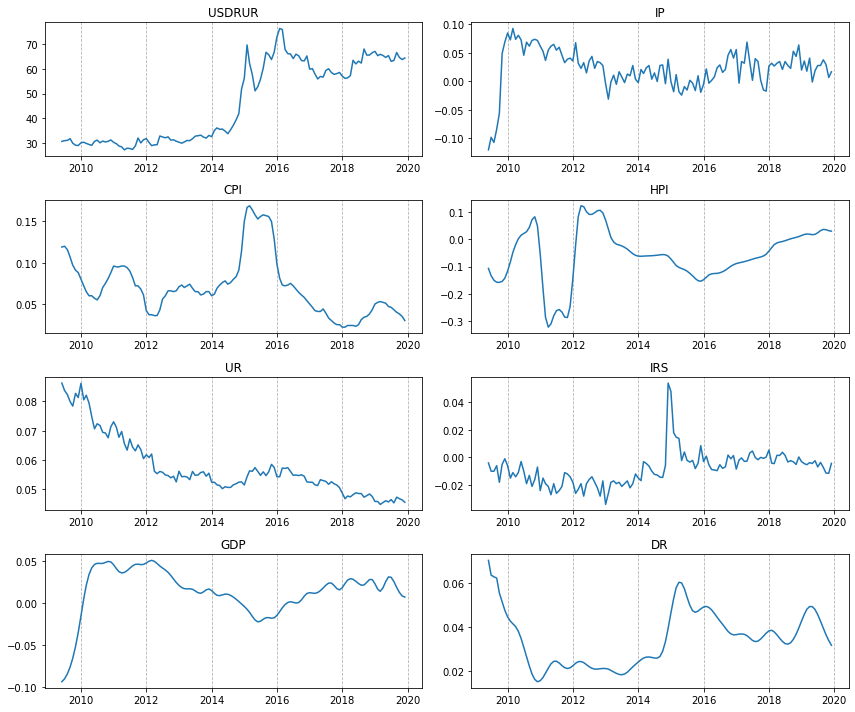

In [43]:
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(12,10))
for i, ax in enumerate(axes.flatten()):
    try:
        graph = df[df.columns[i]]
        ax.plot(graph)
        ax.set_title(df.columns[i])
        ax.grid(axis = 'x', linestyle='--', color='k', alpha=0.3)
    except IndexError:
        print("")
plt.tight_layout()

In [44]:
df.info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2009-06-01 to 2019-12-01
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   USDRUR  127 non-null    float64
 1   IP      127 non-null    float64
 2   CPI     127 non-null    float64
 3   HPI     127 non-null    float64
 4   UR      127 non-null    float64
 5   IRS     127 non-null    float64
 6   GDP     127 non-null    float64
 7   DR      127 non-null    float64
dtypes: float64(8)
memory usage: 8.9 KB


<h3>II. Тест причинной связи и корреляции временных рядов

Таблица коэффициентов корреляции

<AxesSubplot:>

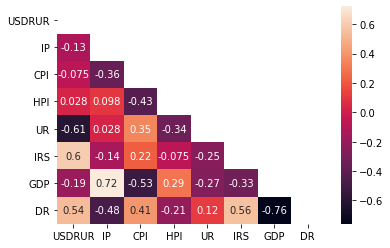

In [45]:
df_w_date = pd.DataFrame(data)

corr = df_w_date.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot=True, mask=mask)

GDP и IP имеют высокую парную корреляцию (>0,7). <br>
Использовать их совместно в будущей модели нежелательно.

In [46]:
df = copy(df.drop(columns=['IP']))


Тест Грэнджера на причинность <br>
<br>
Для наличия причинной связи в тесте важно, чтобы предшествующие значения «причины» (X) оказывали
ощутимое влияние на будущие значения «следствия» (Y) и притом прошлые значения «следствия» (Y)
не оказывали существенного влияния на будущие значения «причины» (X). <br>
Это происходит при p_value < p_крит (0,05), см. ниже:

In [47]:
maxlag = 12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test=test, verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)

,USDRUR_x,CPI_x,HPI_x,UR_x,IRS_x,GDP_x,DR_x
USDRUR_y,1.0000,0.0023,0.9127,0.0451,0.0000,0.5010,0.0000
CPI_y,0.0035,1.0000,0.0000,0.0736,0.0007,0.0289,0.0000
HPI_y,0.8239,0.0001,1.0000,0.0209,0.3300,0.0000,0.1756
UR_y,0.0133,0.0000,0.0003,1.0000,0.1225,0.0003,0.0000
IRS_y,0.0286,0.1590,0.5998,0.1332,1.0000,0.2203,0.0008
GDP_y,0.0030,0.0027,0.0054,0.0000,0.0585,1.0000,0.0000
DR_y,0.0001,0.0211,0.2114,0.0000,0.0000,0.0000,1.0000


HPI обладает слабой причинной связью с DR, поэтому также будет исключен из дальнейшего рассмотрения.

In [48]:
df = copy(df.drop(columns=['HPI']))



<h3>III. Тест на стационарность

Тест Дики Фуллера на исходных временных рядах <br>
<br>
Стационарность или постоянство — свойство процесса не менять свои характеристики, не изменять распределение
вероятности при смещении во времени. <br>
Любые стационарные данные могут быть аппроксимированы (смоделированы) моделями ARMA. <br>
При p < p_крит временной ряд признается стационарным.

In [49]:
for i in range(len(df.columns)):
    print(str(df.columns[i]))
    result = adfuller(df.iloc[:,i])
    print('p-value: %f' % result[1])
    if result[1] <= 0.05:
        print('Stationary at the 95% confidence level')

USDRUR
p-value: 0.842071
CPI
p-value: 0.467691
UR
p-value: 0.085313
IRS
p-value: 0.000891
Stationary at the 95% confidence level
GDP
p-value: 0.268750
DR
p-value: 0.588901


Графики функций автокорреляции и частичной автокорреляции

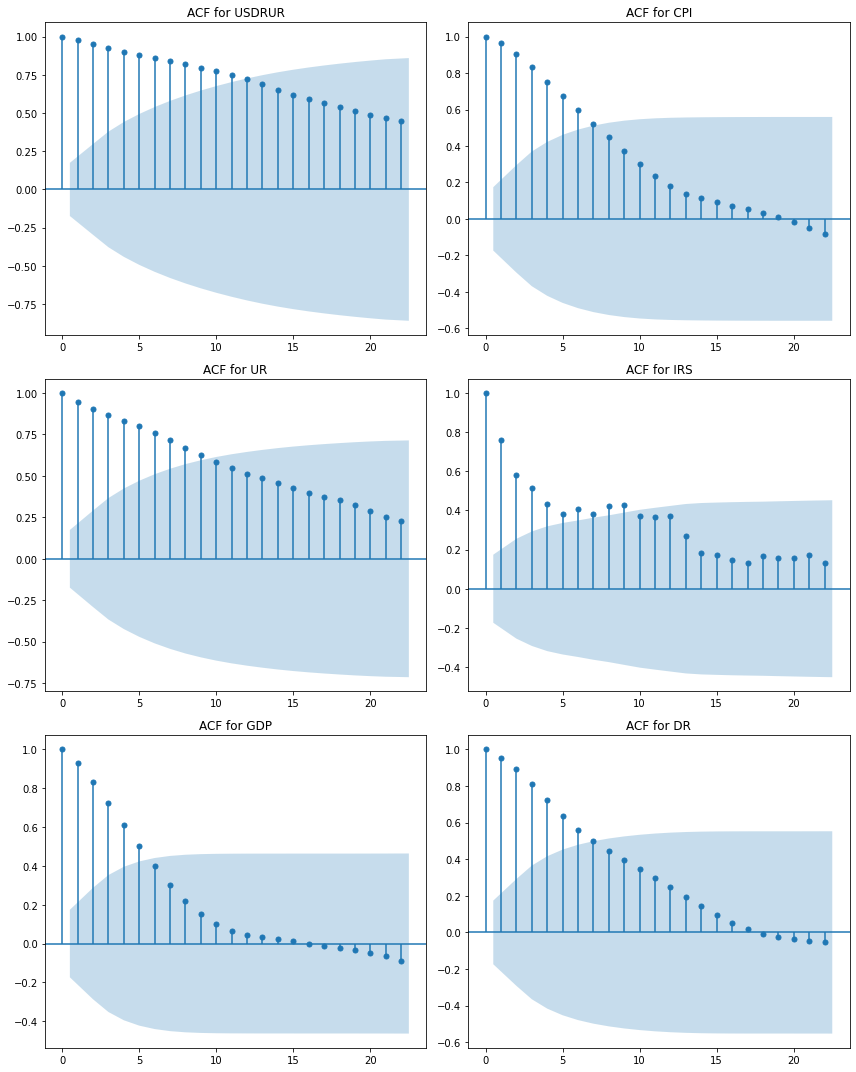

In [50]:
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(12,15))
for i, ax in enumerate(axes.flatten()):
    data_acf = df[df.columns[i]]
    plot_acf(data_acf, ax=axes[i//2][i%2])
    ax.set_title('ACF for '+df.columns[i])
plt.tight_layout()

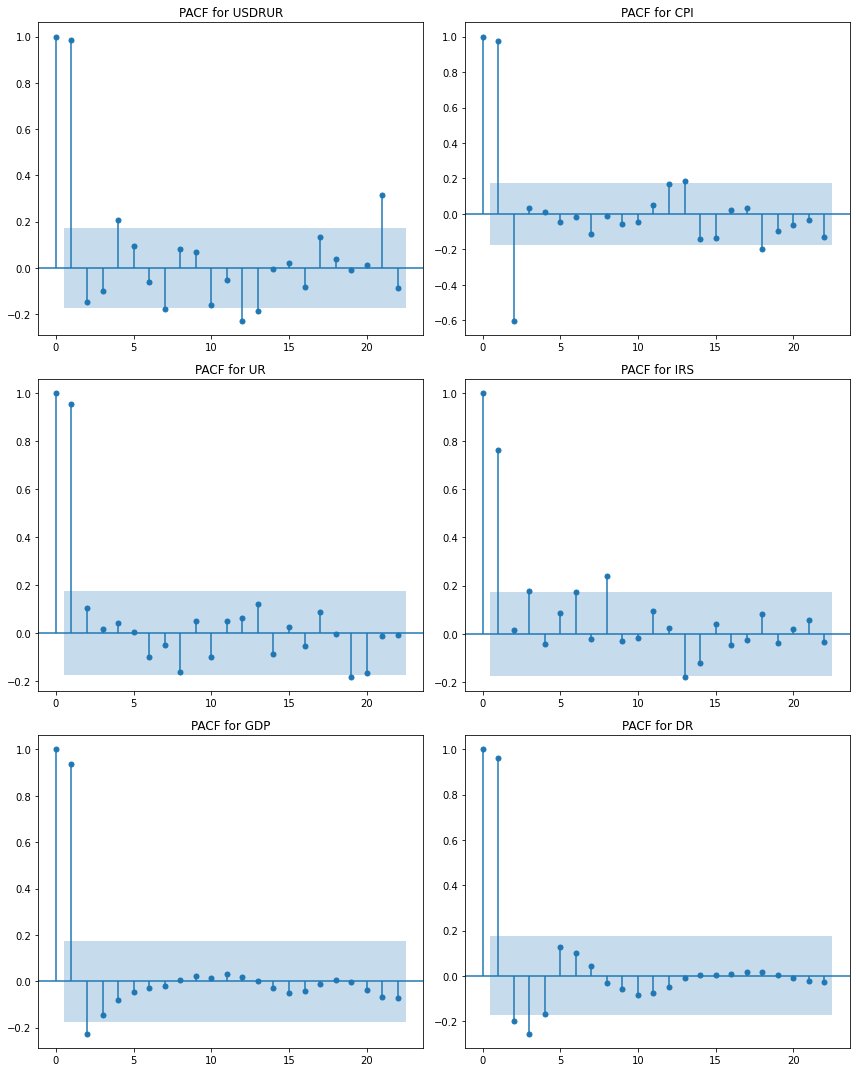

In [51]:
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(12,15))
for i, ax in enumerate(axes.flatten()):
    data_pacf = df[df.columns[i]]
    plot_pacf(data_pacf, ax=axes[i//2][i%2])
    ax.set_title('PACF for '+df.columns[i])
plt.tight_layout()



<h3>IV. Трансформация рядов

In [52]:
df_std_by_year = copy(df)
normalized_df = copy(df)
diffed_df = copy(df)
diffed_df_1 = copy(df)
stabilized_df = copy(df)

Для достижения стационарности будет использован параметр d, диффиренцирующий ряд в SARIMAX(p,d,q)
модели для избавления от трендовой составляющей. <br>
Продемонстрируем ряды и тест Дики Фуллера после такой дифференциации

In [53]:
for i in df:
    # normalized
    avg, std = df[i].mean(), df[i].std()
    normalized_df[i] = (df[i] - avg) / std
    # diffed
    diffed_df[i] = normalized_df[i].diff().fillna(normalized_df[i].mean())

# diffed_df_1['DR'] = copy(diffed_df['DR'])
# diffed_df['DR'] = diffed_df['DR'].diff().fillna(diffed_df['DR'].mean())
stabilized_df = copy(diffed_df)

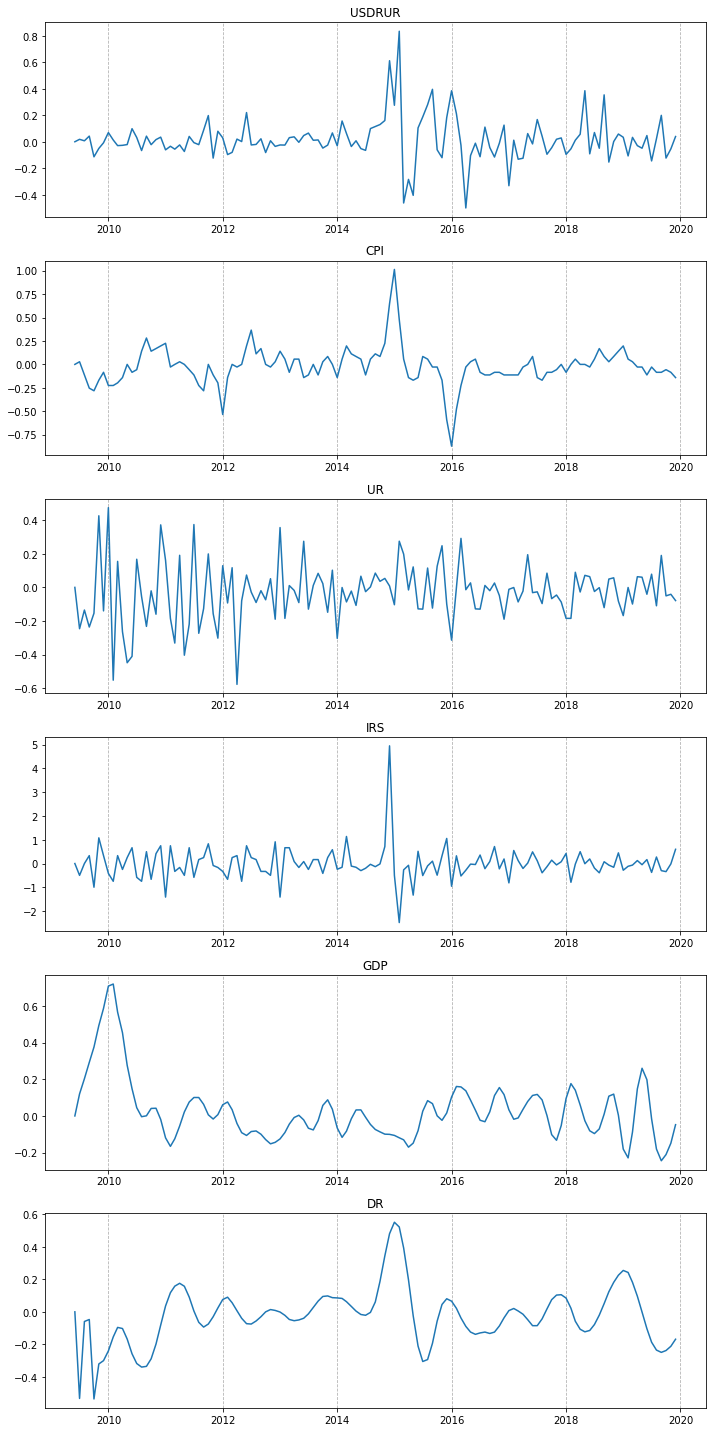

In [54]:
fig, axes = plt.subplots(nrows=len(stabilized_df.columns),figsize=(10,20))
for i, ax in enumerate(axes.flatten()):
    graph = stabilized_df[stabilized_df.columns[i]]
    ax.plot(graph)
    ax.set_title(stabilized_df.columns[i])
    ax.grid(axis = 'x', linestyle='--', color='k', alpha=0.3)
plt.tight_layout()

Некоторая неоднородность дисперсии в графиках объясняется последствиями 2 кризисов
(2008-09 и 2014-15гг.) и не является блокирующим препятствием для SARIMAX моделирования, пока
тест на стационарность выполняется (см. ниже). Также чрезмерная трансформация рядов может привести к
сильному разбросу оценок в прогнозируемом периоде после проведения обратных трансформаций.<br>
Все значения p-value меньше или близки к p_крит = 0,05. <br>
Для баланса между предсказательной силой и простотой трансформаций ограничимся нормализацией и
однократной диффиеренциацией временных рядов.

In [55]:
for i in range(len(stabilized_df.columns)):
    print(str(stabilized_df.columns[i]))
    result = adfuller(stabilized_df.iloc[:,i])
    print('p-value: %f' % result[1])
    if result[1] <= 0.05:
        print('Stationary at the 95% confidence level')
    else:
        print('Stationary at the 90% confidence level')

USDRUR
p-value: 0.000000
Stationary at the 95% confidence level
CPI
p-value: 0.007489
Stationary at the 95% confidence level
UR
p-value: 0.000000
Stationary at the 95% confidence level
IRS
p-value: 0.000000
Stationary at the 95% confidence level
GDP
p-value: 0.000000
Stationary at the 95% confidence level
DR
p-value: 0.060203
Stationary at the 90% confidence level


In [56]:
stabilized_df = copy(normalized_df)



<h3>V. Поиск оптимального порядка SARIMAX и обучение модели

In [57]:
df_sarimax = pd.DataFrame()

""


In [58]:
# for i in range(0,5):
#     for j in range(0,5):
#         model = SARIMAX(stabilized_df['DR'], exog=stabilized_df[['USDRUR','UR','IRS','GDP']],
#                         order=(i,1,j),
#                         )
#         model_fit = model.fit(disp=False)
#         model_fit.save('sarimax_results')
#         results_ = SARIMAXResults.load('sarimax_results')
#
#         df_sarimax = pd.DataFrame(index=pd.Series(results_.param_names))
#         df_sarimax['coefs'] = results_.params.round(decimals=2)
#         df_sarimax['pvalues'] = results_.pvalues.round(decimals=2)
#
#         print('Model ', i, '1', j)
#         print(df_sarimax)

Оптимальный порядок SARIMAX(0,1,2 (0,0,0)). <br>
То есть по сути это модель ARIMA(0,1,2) с 4 объсняющими переменными (X)

In [59]:
endog = copy(stabilized_df['DR'])
exog = copy(stabilized_df[['USDRUR','UR','IRS','GDP']])

Обучение модели происходит на периоде 06.2009-03.2019. <br>
Тестовый набор данных - последние 8 месяцев наблюдений (05-12.2019).

Полученные коэффициенты спецификации модели для DR, их значимость и статистика модели:

In [60]:
n = 8
model = SARIMAX(endog[:-n], exog=exog[:-n], order=(0,1,2))
model_fit = model.fit(disp=False)

model_fit.save('sarimax_results')
results_ = SARIMAXResults.load('sarimax_results')
df_sarimax = pd.DataFrame(index=pd.Series(results_.param_names))
df_sarimax['coefs'] = results_.params.round(decimals=2)
df_sarimax['pvalues'] = results_.pvalues.round(decimals=2)

print(df_sarimax)
model_fit.summary()



        coefs  pvalues
USDRUR  -0.03     0.04
UR       0.04     0.00
IRS      0.01     0.02
GDP     -0.47     0.00
ma.L1    1.40     0.00
ma.L2    0.41     0.00
sigma2   0.01     0.00


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     DR   No. Observations:                  119
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 127.655
Date:                Mon, 21 Jun 2021   AIC                           -241.309
Time:                        11:07:37   BIC                           -221.914
Sample:                    06-01-2009   HQIC                          -233.434
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
USDRUR        -0.0303      0.015     -2.039      0.041      -0.059      -0.001
UR             0.0433      0.010      4.258      0.000       0.023       0.063
IRS            0.0055      0.002      2.315      0.021       0.001       0.010
GDP           -0.4673      0.063     -7.427      0.000      -0.591      -0.344
ma.L1          1.4008      0.265      5.293      0.000       0.882       1.919
ma.L2          0.4069      0.116      3.511      0.000       0.180       0.634
sigma2         0.0064      0.002      3.726      0.000       0.003       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                22.80
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.16   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<h3>VI. Проверка предсказательной силы модели на тестовом сете

Мы хотим получить результаты для всех данных, но используя оцененные
на тренировочном сете параметры (коэффициенты).

In [61]:
mod = SARIMAX(endog, exog=exog, order=(0,1,2))
res = mod.filter(model_fit.params)

In [62]:
predict = res.get_prediction()
predict_error = predict.predicted_mean[-n:] - endog[-n:]

График актуальных и предсказанных значений DR на тестовом периоде

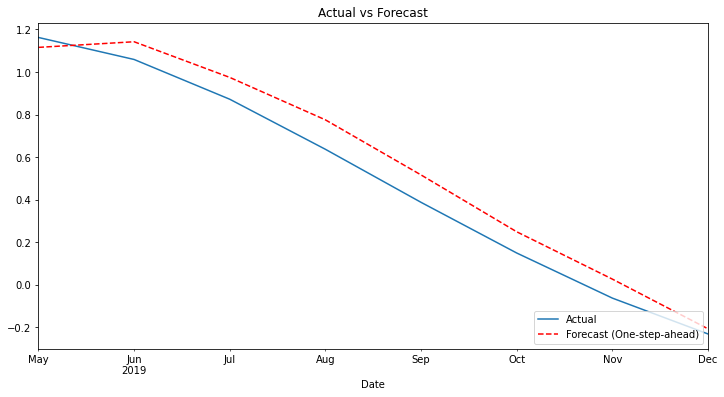

In [63]:
fig, ax = plt.subplots(figsize=(12,6))
endog[-n:].plot(ax=ax, style='-', label='Actual')
predict.predicted_mean[-n:].plot(ax=ax, style='r--', label='Forecast (One-step-ahead)')
ax.set_title('Actual vs Forecast')
legend = ax.legend(loc='lower right')

График ошибок (центрированы у нуля)

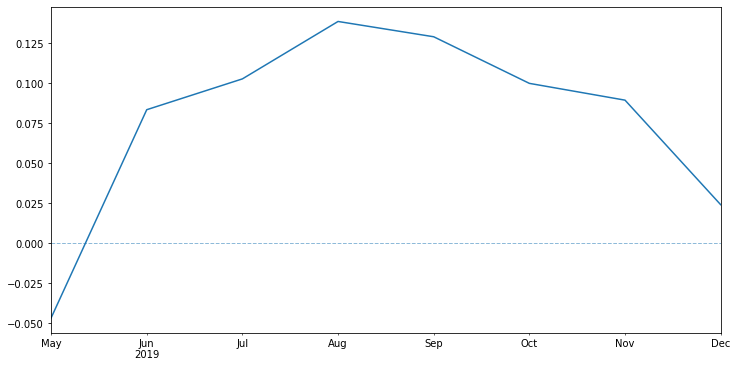

In [64]:
fig, ax = plt.subplots(figsize=(12,6))
predict_error.plot(ax=ax, label='One-step-ahead forecast')
ax.axhline(0, linestyle='--', linewidth=1, alpha=0.5)

In [65]:
forecast_in_sample = pd.DataFrame(index=endog.index, columns=['DR'])
forecast_in_sample['DR'] = copy(predict.predicted_mean)
forecast_in_sample

,DR
Date,
2009-06-01,1.928582
2009-07-01,2.762469
2009-08-01,1.906248
2009-09-01,2.336336
2009-10-01,1.928232
...,...
2019-08-01,0.774813
2019-09-01,0.515620
2019-10-01,0.248187


Функция обратной трансформации

In [66]:
def norm_inv(initial_series, normalized_series):
    avg, std = initial_series.mean(), initial_series.std()
    series = normalized_series * std + avg
    return series

In [67]:
diffed_df_inv = pd.DataFrame()
normalized_df_inv = pd.DataFrame()
df_inv = pd.DataFrame()
endog = pd.DataFrame(endog)
df_endog_inv = pd.DataFrame()
df_exog_inv = pd.DataFrame()
forecast_train_inv = pd.DataFrame()

Полученный ряд уровней дефолтов:

In [68]:
for i in forecast_in_sample:
    print(i)
    forecast_train_inv[i] = norm_inv(df[i], forecast_in_sample[i])
print(forecast_train_inv)

DR
                  DR
Date                
2009-06-01  0.058777
2009-07-01  0.069264
2009-08-01  0.058496
2009-09-01  0.063905
2009-10-01  0.058773
...              ...
2019-08-01  0.044268
2019-09-01  0.041008
2019-10-01  0.037645
2019-11-01  0.034844
2019-12-01  0.031902

[127 rows x 1 columns]


График актуальных и предсказанных значений DR на всем периоде

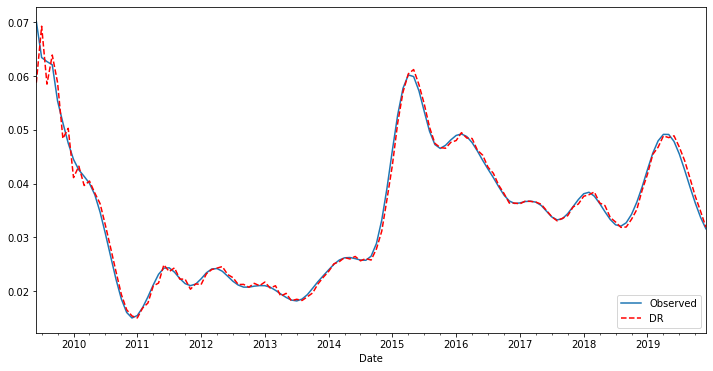

In [69]:
fig, ax = plt.subplots(figsize=(12,6))
df['DR'].plot(ax=ax, style='-', label='Observed')
forecast_train_inv.plot(ax=ax, style='r--', label='One-step-ahead forecast')
legend = ax.legend(loc='lower right')

In [70]:
def adjust(val, length= 6): return str(val).ljust(length)


Cтатистика Дарбина Уотсона (проверка автокорреляции остатков модели) <br>
Чем ближе коэффициенты корреляции к 2, тем меньше связи в остатках. Нормальные значения: 1.5-2.5. <br>
Выбранная спецификация модели обладает хорошим качеством.

In [71]:
print("Статистика DW автокорреляции остатков в DR:")
print(round(durbin_watson(model_fit.resid),2))

Статистика DW автокорреляции остатков в DR:
2.15


In [72]:
model_fit.resid

Date
2009-06-01    0.903962
2009-07-01   -0.463378
2009-08-01    0.333363
2009-09-01   -0.143926
2009-10-01   -0.272471
                ...   
2018-12-01    0.048244
2019-01-01    0.068503
2019-02-01    0.017705
2019-03-01    0.093831
2019-04-01    0.022613
Length: 119, dtype: float64

Точность прогнозов модели ARIMAX(0,1,2): Default Rate

In [73]:
def adjust(val, length= 6): return str(val).ljust(length)
def forecast_accuracy(forecast, actual):
    mpe = np.mean((forecast - actual)/actual)   # Mean Percentage Error
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # Mean Abs Percentage Error
    me = np.mean(forecast - actual)             # Mean Error
    mae = np.mean(np.abs(forecast - actual))    # Mean Abs Error
    rmse = np.mean((forecast - actual)**2)**.5  # Root Mean Square Error
    corr = np.corrcoef(forecast, actual)[0,1]   # correlation

    return{'Mean Percentage Error': mpe, 'Mean Abs Percentage Error':mape, 'Mean Error':me,
           'Mean Abs Error': mae, 'Root Mean Square Error':rmse, 'correlation':corr}

accuracy_prod = forecast_accuracy(forecast_train_inv['DR'], df['DR'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))



Mean Percentage Error :  0.0002
Mean Abs Percentage Error :  0.0234
Mean Error :  -0.0
Mean Abs Error :  0.0009
Root Mean Square Error :  0.0015
correlation :  0.9924


<h3>VII. Прогнозирование на период 01.2020-12.2022.

Набор фактических и прогнозных данных выбранных макрофакторов на 2020-2022 гг.

In [74]:
df_future = pd.read_csv('data/df_future.csv', parse_dates=['Date'],index_col=0)
df_future = df_future.drop(columns=['HPI','DR','CPI'])
df_future

,USDRUR,UR,IRS,GDP
Date,,,,
2020-01-01,61.905700,0.044018,-0.009600,0.008675
2020-02-01,63.138500,0.043076,-0.005600,0.008395
2020-03-01,66.327400,0.044875,-0.003600,0.002047
2020-04-01,76.407400,0.056178,-0.013000,-0.013913
2020-05-01,72.726300,0.062548,-0.009800,-0.032341
2020-06-01,69.711400,0.064432,-0.002400,-0.045954
2020-07-01,70.441300,0.065138,-0.011500,-0.047848
2020-08-01,73.426100,0.067590,-0.009500,-0.040969
2020-09-01,73.803900,0.066292,-0.006600,-0.030352


In [75]:
normalized_df_fut = pd.DataFrame()
n_fcst = 35
for i in df_future:
    avg, std = df_future[i].mean(), df_future[i].std()
    normalized_df_fut[i] = (df_future[i] - avg) / std

df_future_stab = copy(normalized_df_fut)
predict = res.get_prediction(end=mod.nobs + n_fcst, exog=df_future_stab)

forecast_out_of_sample = pd.DataFrame(index=df_future.index, columns=['DR'])
forecast_out_of_sample['DR'] = copy(predict.predicted_mean)

Предсказанные значения DR на 2020-2022 гг.

In [76]:
avg, std = df['DR'].mean(), df['DR'].std()
forecast_out_of_sample_inv = forecast_out_of_sample * std + avg
print(forecast_out_of_sample_inv)

                  DR
Date                
2020-01-01  0.031265
2020-02-01  0.031108
2020-03-01  0.032044
2020-04-01  0.034266
2020-05-01  0.038401
2020-06-01  0.041415
2020-07-01  0.041408
2020-08-01  0.040208
2020-09-01  0.038377
2020-10-01  0.036053
2020-11-01  0.035348
2020-12-01  0.037101
2021-01-01  0.037383
2021-02-01  0.035673
2021-03-01  0.034429
2021-04-01  0.032948
2021-05-01  0.028827
2021-06-01  0.024831
2021-07-01  0.020550
2021-08-01  0.022800
2021-09-01  0.025072
2021-10-01  0.027232
2021-11-01  0.027371
2021-12-01  0.027523
2022-01-01  0.027600
2022-02-01  0.027408
2022-03-01  0.027213
2022-04-01  0.026954
2022-05-01  0.026540
2022-06-01  0.026127
2022-07-01  0.025655
2022-08-01  0.025048
2022-09-01  0.024450
2022-10-01  0.023805
2022-11-01  0.023614
2022-12-01  0.023431


График актуальных (до 2020 г.) и предсказанных значений (2020-22 гг.) DR

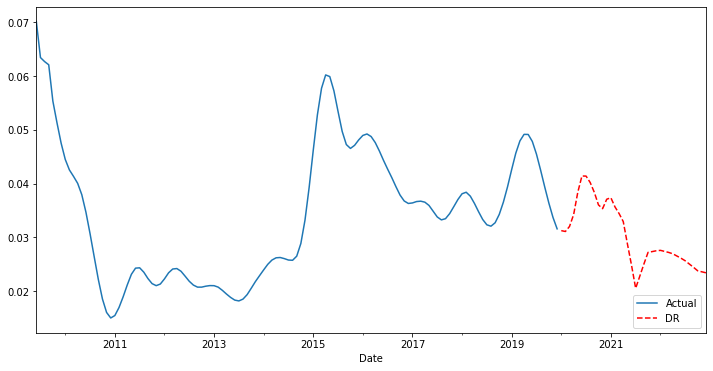

In [77]:
fig, ax = plt.subplots(figsize=(12,6))
df['DR'].plot(ax=ax, style='-', label='Actual')
forecast_out_of_sample_inv.plot(ax=ax, style='r--', label='Forecast')
legend = ax.legend(loc='lower right')

In [78]:
data

,USDRUR,IP,CPI,HPI,UR,IRS,GDP,DR
Date,,,,,,,,
2009-06-01,30.7441,-0.120,0.119,-0.106610,0.086256,-0.0040,-0.093971,0.070145
2009-07-01,31.0385,-0.098,0.120,-0.133454,0.083749,-0.0100,-0.090556,0.063437
2009-08-01,31.1533,-0.107,0.116,-0.149758,0.082376,-0.0100,-0.084786,0.062689
2009-09-01,31.8397,-0.084,0.107,-0.157354,0.079971,-0.0060,-0.076486,0.062095
2009-10-01,30.0087,-0.056,0.097,-0.157706,0.078403,-0.0180,-0.065809,0.055346
...,...,...,...,...,...,...,...,...
2019-08-01,63.4172,0.028,0.043,0.031834,0.045412,-0.0036,0.025937,0.042526
2019-09-01,66.6235,0.038,0.040,0.036447,0.047352,-0.0072,0.018987,0.039387
2019-10-01,64.6407,0.030,0.038,0.035385,0.046838,-0.0113,0.012993,0.036389
